# **AI Detector**
This notebook is designed to detect whether a piece of text is written by a human or generated by a GPT-like language model. We'll use various machine learning models to classify the text and evaluate their performance.


Steps to run this file
- Load in Google colab
- Make a folder "templates" and place the file "index.html" in it
- Run all, done

## Install Required Libraries
First, we need to install the necessary libraries for our analysis and modeling.


In [ ]:
# Install required libraries
!pip install datasets
!pip install scikit-learn
!pip install tensorflow
!pip install matplotlib
!pip install nltk
!pip install transformers
!pip install imbalanced-learn

## Import Libraries and Load Dataset
After installing the required libraries, we import them and load the dataset for our analysis.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import transformers
from transformers import BertTokenizer, TFBertModel
from imblearn.over_sampling import SMOTE

## Exploratory Data Analysis (EDA)
We'll perform some basic exploratory data analysis to understand the distribution of our data and its characteristics.


In [ ]:
# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load the dataset
dataset = load_dataset("aadityaubhat/GPT-wiki-intro")
print("Dataset loaded successfully.")
# Define text preprocessing functions
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Dataset loaded successfully.


In [ ]:
# Use only 20% of the dataset
dataset_size = len(dataset['train'])
subset_size = int(dataset_size * 0.1)
dataset = dataset['train'].shuffle(seed=42).select(range(subset_size))
print(f"Using a subset of the dataset with {subset_size} rows.")

Using a subset of the dataset with 15000 rows.


In [ ]:
# Create a DataFrame for human-written content
human_df = pd.DataFrame({
    'Text': dataset['wiki_intro'],
    'Label': 0
})

# Create a DataFrame for AI-generated content
ai_df = pd.DataFrame({
    'Text': dataset['generated_intro'],
    'Label': 1
})

# Combine the DataFrames
combined_df = pd.concat([human_df, ai_df], ignore_index=True)

# Optionally, shuffle the combined DataFrame
combined_df = combined_df.sample(frac=1).reset_index(drop=True)

# Add columns for word count and character count
combined_df['Word Count'] = combined_df['Text'].apply(lambda text: len(text.split()))
combined_df['Char Count'] = combined_df['Text'].apply(len)
combined_df

,Text,Label,Word Count,Char Count
0,"William Craig Fugate (born May 14, 1959) is th...",0,148,874
1,Anwar al-Khatib (; 1917–1993) was a Palestinia...,1,242,1500
2,"Zendstation Smilde, also known as the CJ2 Data...",0,183,1100
3,"Used in hydrogeology, the groundwater flow equ...",1,54,325
4,"Reverend Agapius Honcharenko (; August 31, 183...",0,185,1146
...,...,...,...,...
29995,"Expanding bullets, also known colloquially as ...",0,186,1156
29996,Aaron Anthony Rhodes (born 1949) is an America...,0,208,1329
29997,"""Crazier"" is a song by American singer-songwri...",1,166,992
29998,A plasma antenna is a type of antenna which us...,1,34,222


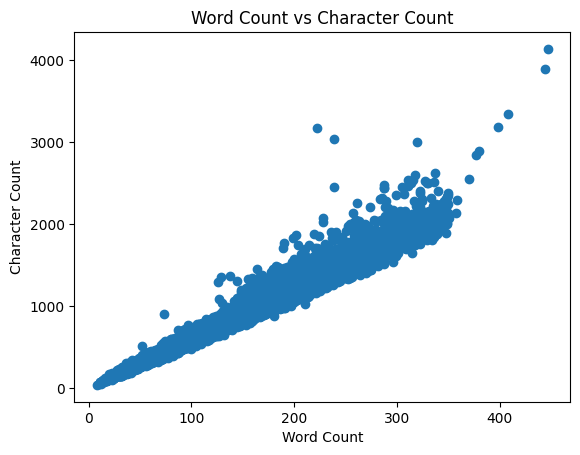

In [ ]:
# @title Word Count vs Character Count

import matplotlib.pyplot as plt
plt.scatter(combined_df['Word Count'], combined_df['Char Count'])
plt.title('Word Count vs Character Count')
plt.xlabel('Word Count')
_ = plt.ylabel('Character Count')

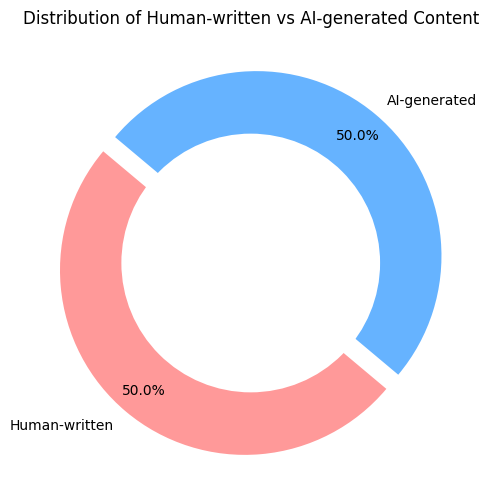

In [ ]:
import matplotlib.pyplot as plt

# Calculate the distribution
label_counts = combined_df['Label'].value_counts()

# Define labels and colors for the pie chart
labels = ['Human-written', 'AI-generated']
colors = ['#ff9999','#66b3ff']

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, pctdistance=0.85, explode=(0.05, 0.05))

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Add a title
plt.title('Distribution of Human-written vs AI-generated Content')

# Show the pie chart
plt.show()

## Data Preprocessing
Before we can train our models, we need to preprocess our text data. This includes cleaning the text, removing stopwords, and other transformations.


In [ ]:
# Split the data into training and testing sets
X = combined_df['Text']
y = combined_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Text preprocessing with batch processing
def preprocess_text_batch(texts, batch_size=1000):
    processed_texts = []
    total_batches = len(texts) // batch_size + 1
    for i in range(total_batches):
        batch = texts[i*batch_size:(i+1)*batch_size]
        processed_batch = batch.apply(preprocess_text)
        processed_texts.extend(processed_batch)
        print(f"Processed batch {i+1}/{total_batches}")
    return processed_texts

def preprocess_text(text):
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])

    # Stemming
    stemmer = PorterStemmer()
    text = ' '.join([stemmer.stem(word) for word in text.split()])

    return text

X_train_processed = preprocess_text_batch(X_train)
X_test_processed = preprocess_text_batch(X_test)

# Convert text to sequences
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
X_train_sequences = tokenizer.batch_encode_plus(X_train.tolist(), max_length=512, pad_to_max_length=True, truncation=True)
X_test_sequences = tokenizer.batch_encode_plus(X_test.tolist(), max_length=512, pad_to_max_length=True, truncation=True)

# Convert sequences to numpy arrays
X_train_padded = np.array(X_train_sequences['input_ids'])
X_test_padded = np.array(X_test_sequences['input_ids'])

# Oversample the minority class
smote = SMOTE()
X_train_padded_oversampled, y_train_oversampled = smote.fit_resample(X_train_padded, y_train)

Processed batch 1/25
Processed batch 2/25
Processed batch 3/25
Processed batch 4/25
Processed batch 5/25
Processed batch 6/25
Processed batch 7/25
Processed batch 8/25
Processed batch 9/25
Processed batch 10/25
Processed batch 11/25
Processed batch 12/25
Processed batch 13/25
Processed batch 14/25
Processed batch 15/25
Processed batch 16/25
Processed batch 17/25
Processed batch 18/25
Processed batch 19/25
Processed batch 20/25
Processed batch 21/25
Processed batch 22/25
Processed batch 23/25
Processed batch 24/25
Processed batch 25/25
Processed batch 1/7
Processed batch 2/7
Processed batch 3/7
Processed batch 4/7
Processed batch 5/7
Processed batch 6/7
Processed batch 7/7


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Visualizations
To gain insights from the data - Important step

<ipython-input-39-497773d3729e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Label', y='Word Count', data=combined_df, palette='muted')


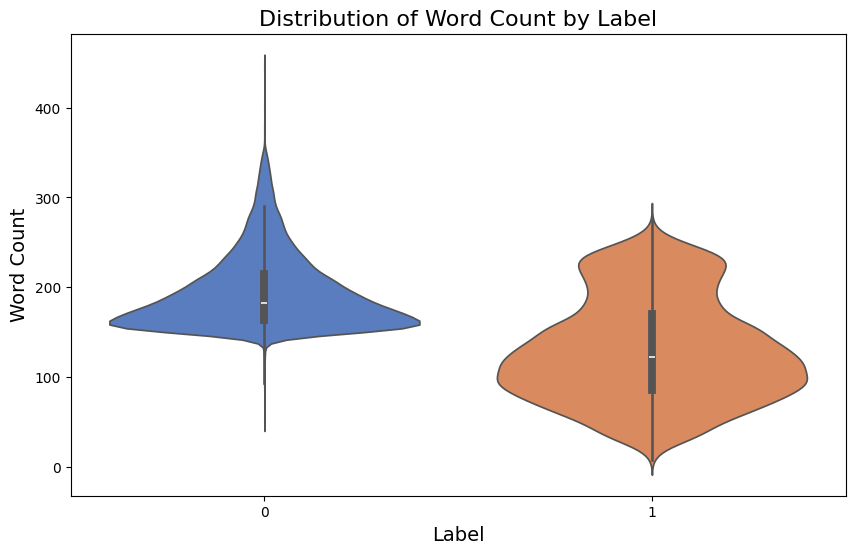

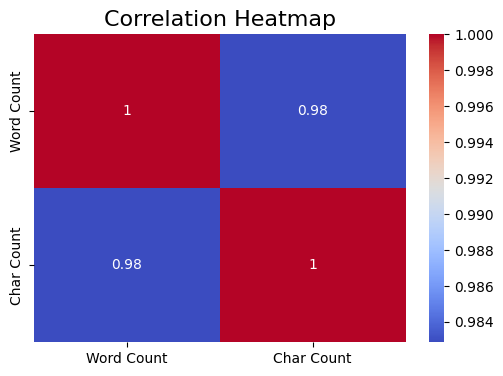

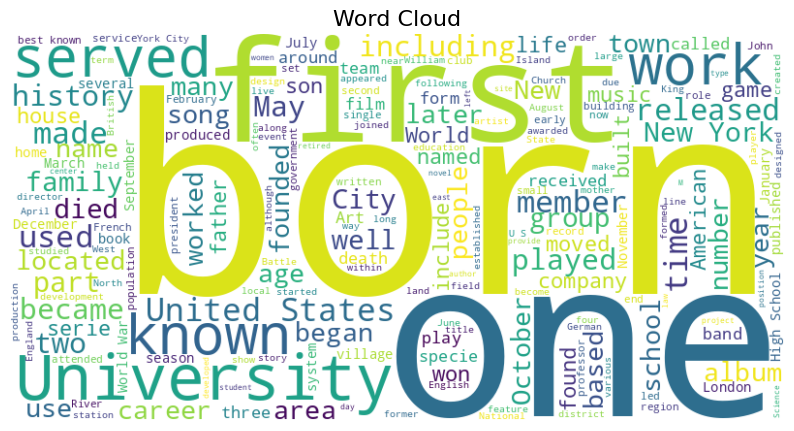

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Label', y='Word Count', data=combined_df, palette='muted')
plt.title('Distribution of Word Count by Label', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Word Count', fontsize=14)
plt.show()

# 2. Heatmap
corr = combined_df[['Word Count', 'Char Count']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap', fontsize=16)
plt.show()

# 3. Word Cloud
from wordcloud import WordCloud

# Combine all text into one string
all_text = ' '.join(combined_df['Text'])

# Create and plot the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud', fontsize=16)
plt.show()

#### Indepth visuals including statistical data

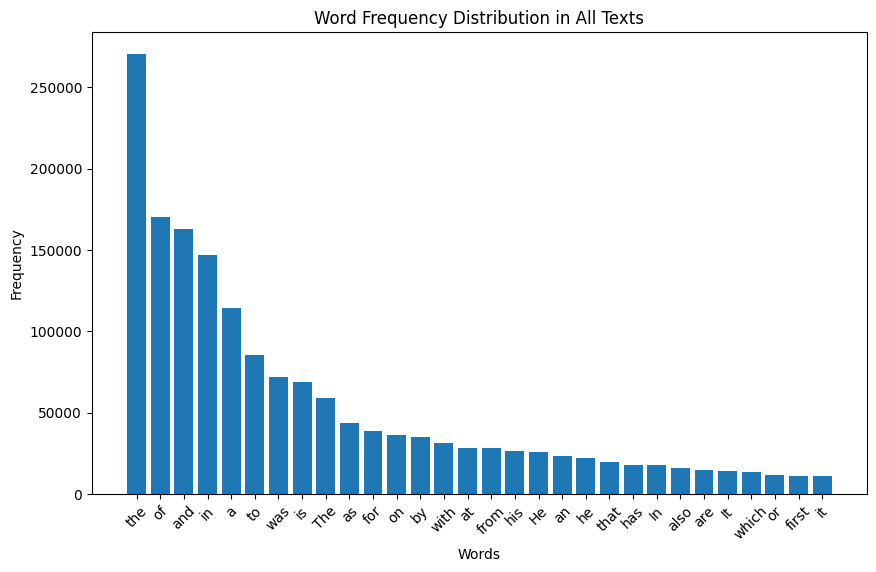

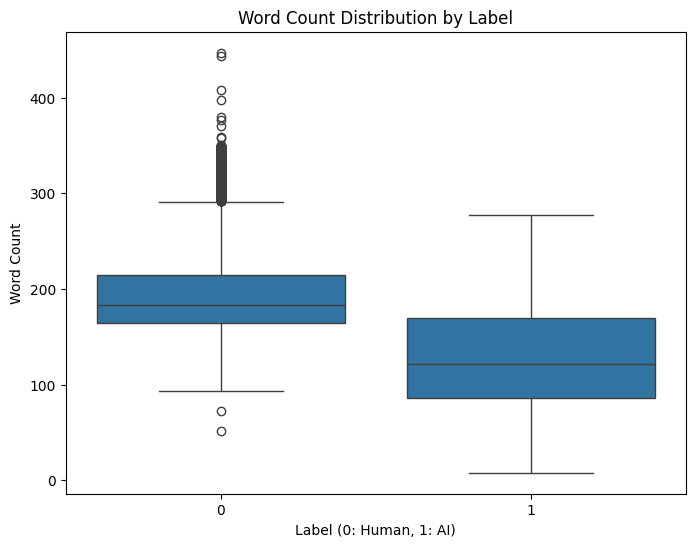

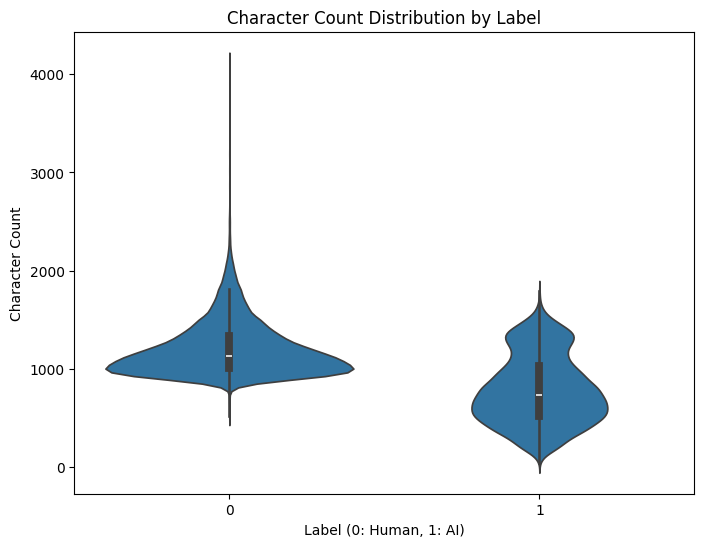

In [ ]:
from collections import Counter
import seaborn as sns

# 1. Word Frequency Distribution
def plot_word_frequency_distribution(text, title, num_words=30):
    words = text.split()
    word_counts = Counter(words)
    most_common_words = word_counts.most_common(num_words)
    words, frequencies = zip(*most_common_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.show()

# Combine all texts for word frequency distribution
all_text = ' '.join(combined_df['Text'])
plot_word_frequency_distribution(all_text, 'Word Frequency Distribution in All Texts')

# 2. Statistical Plots
# (a) Box Plot for Word Count by Label
plt.figure(figsize=(8, 6))
sns.boxplot(x='Label', y='Word Count', data=combined_df)
plt.title('Word Count Distribution by Label')
plt.xlabel('Label (0: Human, 1: AI)')
plt.ylabel('Word Count')
plt.show()

# (b) Violin Plot for Character Count by Label
plt.figure(figsize=(8, 6))
sns.violinplot(x='Label', y='Char Count', data=combined_df)
plt.title('Character Count Distribution by Label')
plt.xlabel('Label (0: Human, 1: AI)')
plt.ylabel('Character Count')
plt.show()

## Model Training and Evaluation
In this section, we'll train different machine learning models on our processed data and evaluate their performance in detecting GPT-generated text.


In [ ]:
# Load CNN model weights
cnn_model = Sequential([
    Embedding(input_dim=len(tokenizer.vocab), output_dim=128, input_length=512),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_model.load_weights('cnn_model_weights.h5')

# Load LSTM model weights
lstm_model = Sequential([
    Embedding(input_dim=len(tokenizer.vocab), output_dim=128, input_length=512),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.load_weights('lstm_model_weights.h5')

# Load Random Forest model
import joblib
rf_model = joblib.load('rf_model.joblib')

# Load Naive Bayes model
import joblib
nb_model = joblib.load('nb_model.joblib')

In [ ]:
# Train and evaluate Naive Bayes
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_padded_oversampled, y_train_oversampled)
y_pred_nb = nb_model.predict(X_test_padded)
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print(f'Naive Bayes Accuracy: {nb_accuracy}')

Naive Bayes Accuracy: 0.693


Random Forest Accuracy: 0.8293333333333334
Epoch 1/5
601/601 [==============================] - 118s 195ms/step - loss: 0.2176 - accuracy: 0.9080 - val_loss: 0.1624 - val_accuracy: 0.9363
Epoch 2/5
601/601 [==============================] - 121s 202ms/step - loss: 0.0422 - accuracy: 0.9875 - val_loss: 0.1571 - val_accuracy: 0.9531
Epoch 3/5
601/601 [==============================] - 113s 188ms/step - loss: 0.0107 - accuracy: 0.9969 - val_loss: 0.2734 - val_accuracy: 0.9402
Epoch 4/5
601/601 [==============================] - 114s 189ms/step - loss: 0.0122 - accuracy: 0.9962 - val_loss: 0.2507 - val_accuracy: 0.9529
Epoch 5/5
188/188 [==============================] - 7s 39ms/step
CNN Accuracy: 0.9586666666666667
Epoch 1/5
601/601 [==============================] - 606s 1s/step - loss: 0.6929 - accuracy: 0.5086 - val_loss: 0.6925 - val_accuracy: 0.5040
Epoch 2/5
601/601 [==============================] - 619s 1s/step - loss: 0.6919 - accuracy: 0.5008 - val_loss: 0.6929 - val_accuracy: 0

NameError: name 'svm_accuracy' is not defined

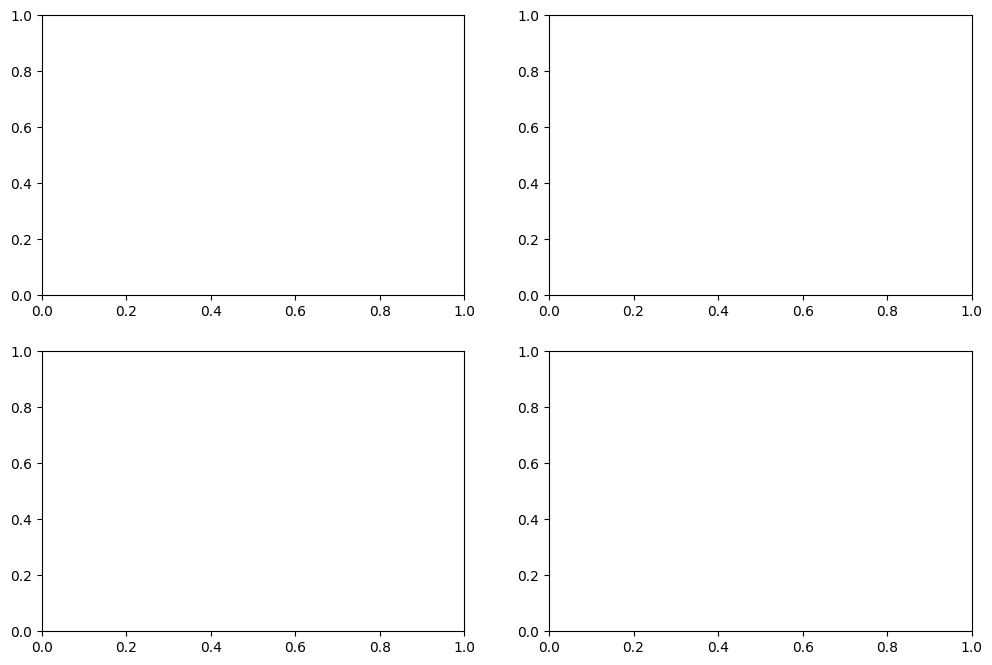

In [ ]:
# Train and evaluate Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_padded_oversampled, y_train_oversampled)
y_pred_rf = rf_model.predict(X_test_padded)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {rf_accuracy}')

# Train and evaluate CNN
cnn_model = Sequential([
    Embedding(input_dim=len(tokenizer.vocab), output_dim=128, input_length=512),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.fit(X_train_padded_oversampled, y_train_oversampled, epochs=5, batch_size=32, validation_split=0.2)
y_pred_cnn = (cnn_model.predict(X_test_padded) > 0.5).astype(int).ravel()
cnn_accuracy = accuracy_score(y_test, y_pred_cnn)
print(f'CNN Accuracy: {cnn_accuracy}')

# Train and evaluate LSTM
lstm_model = Sequential([
    Embedding(input_dim=len(tokenizer.vocab), output_dim=128, input_length=512),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_padded_oversampled, y_train_oversampled, epochs=5, batch_size=32, validation_split=0.2)
y_pred_lstm = (lstm_model.predict(X_test_padded) > 0.5).astype(int).ravel()
lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
print(f'LSTM Accuracy: {lstm_accuracy}')

## Model Comparison
We'll compare the performance of our models to determine which one performs best at detecting GPT-generated text.


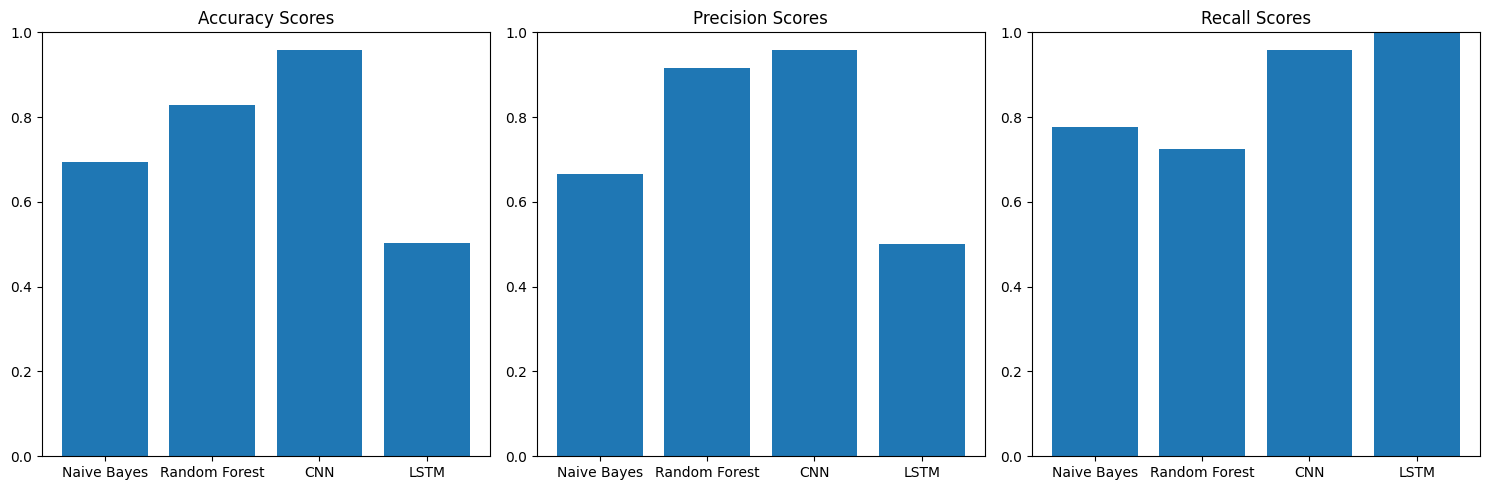

In [ ]:
# Visualize performance using subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].bar(['Naive Bayes', 'Random Forest', 'CNN', 'LSTM'], [nb_accuracy, rf_accuracy, cnn_accuracy, lstm_accuracy])
axs[0].set_title('Accuracy Scores')
axs[0].set_ylim(0, 1)

axs[1].bar(['Naive Bayes', 'Random Forest', 'CNN', 'LSTM'], [precision_score(y_test, y_pred_nb), precision_score(y_test, y_pred_rf), precision_score(y_test, y_pred_cnn), precision_score(y_test, y_pred_lstm)])
axs[1].set_title('Precision Scores')
axs[1].set_ylim(0, 1)

axs[2].bar(['Naive Bayes', 'Random Forest', 'CNN', 'LSTM'], [recall_score(y_test, y_pred_nb), recall_score(y_test, y_pred_rf), recall_score(y_test, y_pred_cnn), recall_score(y_test, y_pred_lstm)])
axs[2].set_title('Recall Scores')
axs[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()